In [1]:
from pathlib import Path
import os
import pandas as pd

dataset_dir = Path('C:\\Users\\ADMIN\\OneDrive\\Documents\\Desktop\\Datasets\\SpeechData')
audio_paths = list(dataset_dir.glob('**/*.wav'))
emotion_labels = [os.path.split(os.path.split(path)[0])[1] for path in audio_paths]
audio_df = pd.DataFrame({'audio_file': audio_paths, 'emotion': emotion_labels}).sample(frac=1).reset_index(drop=True)

In [2]:
import numpy as np
import librosa

***Audio Processing Functions with Some Additional Tunings***

In [3]:
def load_audio(path):
    try:
        data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
        return data, sample_rate
    except Exception as e:
        print(f"Error loading file {path}: {e}")
        return None, None

In [4]:
def add_noise(data):
    noise_value = 0.015 * np.random.uniform() * np.amax(data)
    return data + noise_value * np.random.normal(size=data.shape[0])

In [5]:
def stretch_audio(data, rate=0.9):
    return librosa.effects.time_stretch(data, rate=rate)

In [6]:
def change_pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

***Feature Extraction***

In [7]:
def extract_features(data, sample_rate):
    features = [
        np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_fft=512).T, axis=0),
    ]
    return np.hstack(features)

In [8]:
def export_features(path):
    data, sample_rate = load_audio(path)
    if data is None:
        return np.array([])
    result = [extract_features(data, sample_rate)]
    noisy_data = add_noise(data)
    result.append(extract_features(noisy_data, sample_rate))
    stretched_pitch = change_pitch(stretch_audio(data), sample_rate)
    result.append(extract_features(stretched_pitch, sample_rate))
    return np.array(result)

In [9]:
X_train, y_train = [], []
for path, emotion in zip(audio_df.audio_file, audio_df.emotion):
    features = export_features(path)
    if features.size > 0:
        for element in features:
            X_train.append(element)
            y_train.append(emotion)

In [10]:
feature_dataframe = pd.DataFrame(X_train)
feature_dataframe['EMOTIONS'] = y_train

In [11]:
print(feature_dataframe.head())

            0           1          2          3          4          5  \
0 -564.462463  132.626221  36.641808   6.019323  17.887625  -2.151906   
1 -562.614807  131.403076  36.530829   6.255431  17.642463  -1.913772   
2 -599.973816  137.832840  25.935137  -4.147513  18.368608  -4.411452   
3 -511.636993   55.559437  -0.183221  11.446886 -21.975790  14.940288   
4 -431.414936   32.253087   2.987391  -1.895233 -17.445802   9.356598   

           6          7          8         9  ...         11        12  \
0  -8.040783  -6.315332 -22.038708 -7.476637  ... -12.699783 -4.242810   
1  -8.137285  -6.363460 -21.645832 -7.893189  ... -12.590886 -4.461428   
2 -11.481954 -13.986361 -22.739664 -8.676992  ...  -6.192359  2.008162   
3  -3.389801 -15.823694  -6.652932  0.348489  ...   6.723556 -2.100440   
4  -4.036781 -14.051383  -7.518550 -3.911244  ...  -0.354843  0.213786   

         13        14        15        16        17         18        19  \
0 -5.945600 -3.536090 -1.030246 -7.93273

In [12]:
print(feature_dataframe['EMOTIONS'].value_counts())

EMOTIONS
OAF_Pleasant_surprise     1200
OAF_Fear                  1200
OAF_Sad                   1200
OAF_angry                 1200
OAF_disgust               1095
YAF_pleasant_surprised     600
YAF_neutral                600
YAF_angry                  600
YAF_fear                   600
OAF_happy                  600
OAF_neutral                600
YAF_sad                    600
YAF_disgust                600
YAF_happy                  600
Name: count, dtype: int64


***Checking Some Audio Samples With Above Tunings & Plotting Them***

In [13]:
from IPython.display import Audio
from scipy.io.wavfile import read

In [14]:
rate, speech = read(audio_df['audio_file'][2342])
print(audio_df['emotion'][2342])
Audio(speech, rate=rate, autoplay=False)

OAF_happy


In [15]:
rate, speech = read(audio_df['audio_file'][20])
print(audio_df['emotion'][20])
Audio(speech, rate=rate, autoplay=False)

OAF_disgust


In [16]:
import matplotlib.pyplot as plt
import librosa.display

OAF_Sad


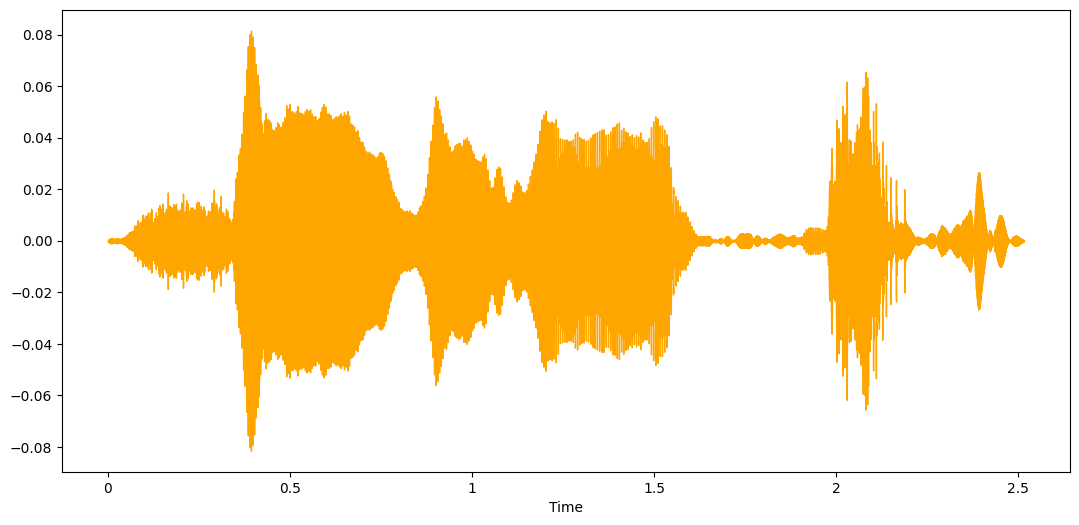

In [17]:
figure = plt.figure(figsize=(13,6))
audio_speech,rate = librosa.load(audio_df['audio_file'][120])
print(audio_df['emotion'][120])
librosa.display.waveshow(audio_speech, sr=rate, color = 'orange')
Audio(audio_speech, rate=rate)

OAF_Fear


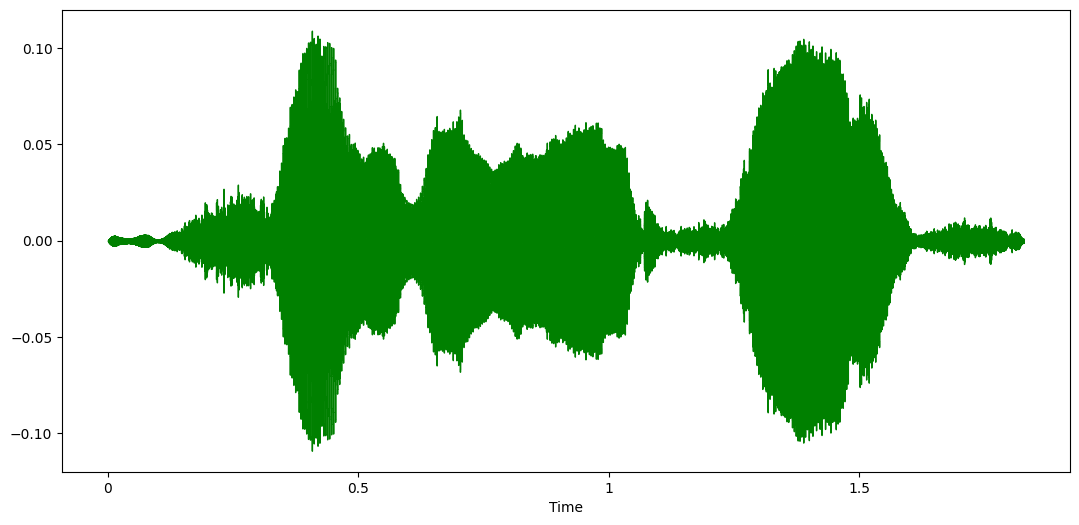

In [18]:
figure = plt.figure(figsize=(13,6))
audio_speech,rate = librosa.load(audio_df['audio_file'][10])
print(audio_df['emotion'][10])
librosa.display.waveshow(audio_speech, sr=rate, color = 'green')
Audio(audio_speech, rate=rate)

YAF_sad


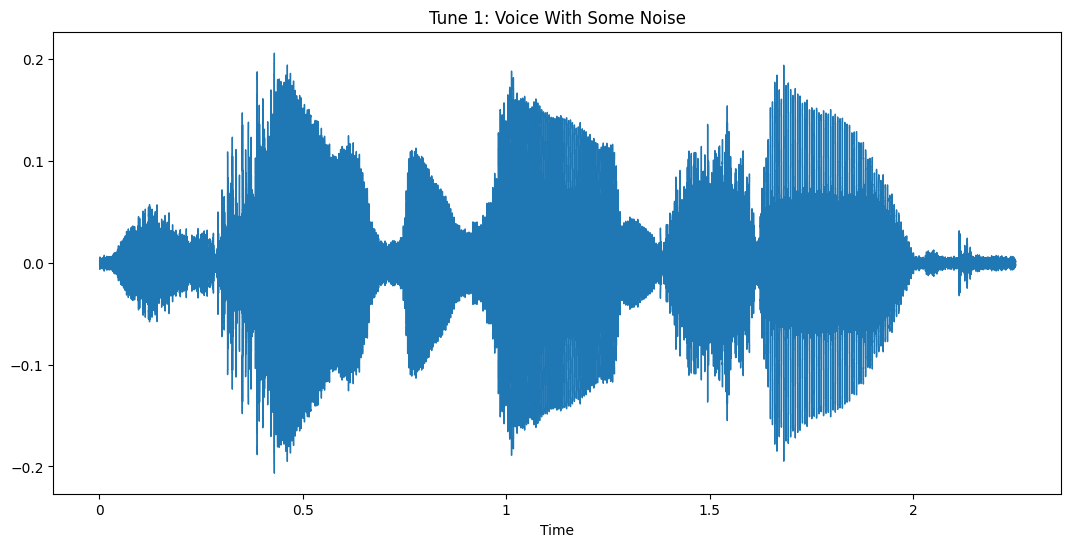

In [19]:
figure = plt.figure(figsize=(13,6))
plt.title("Tune 1: Voice With Some Noise")
audio_speech,sample_rate = librosa.load(audio_df['audio_file'][2000])
print(audio_df['emotion'][2000])
noise_injection = add_noise(audio_speech)
librosa.display.waveshow(noise_injection, sr=sample_rate)
Audio(noise_injection, rate=sample_rate)

YAF_sad


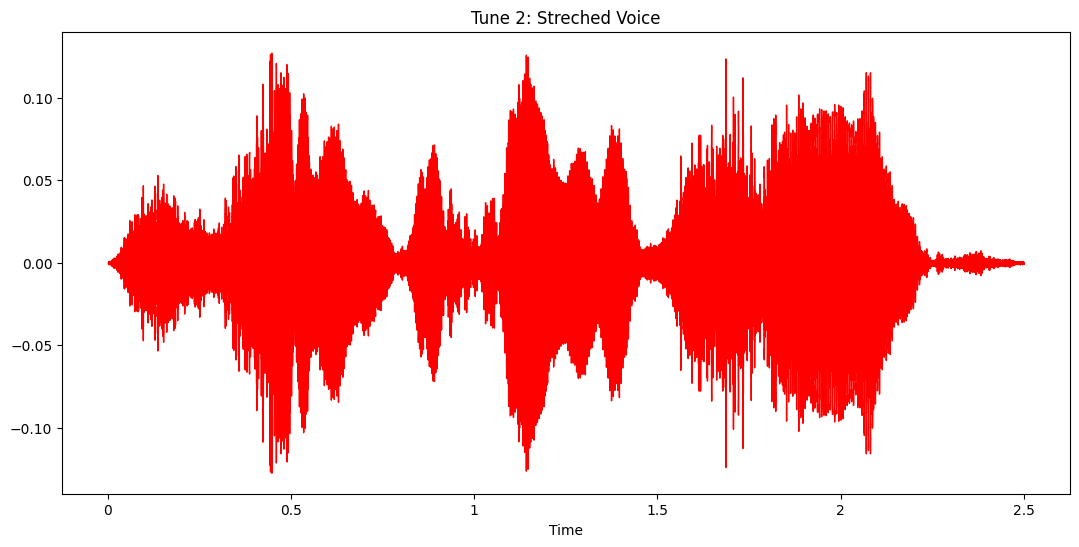

In [20]:
figure = plt.figure(figsize=(13,6))
plt.title("Tune 2: Streched Voice")
audio_speech,sample_rate = librosa.load(audio_df['audio_file'][2000])
print(audio_df['emotion'][2000])
stretching_audio = stretch_audio(audio_speech)
librosa.display.waveshow(stretching_audio, sr=sample_rate, color='red')
Audio(stretching_audio, rate=sample_rate)

***Spectrogram of a Audio Sample***

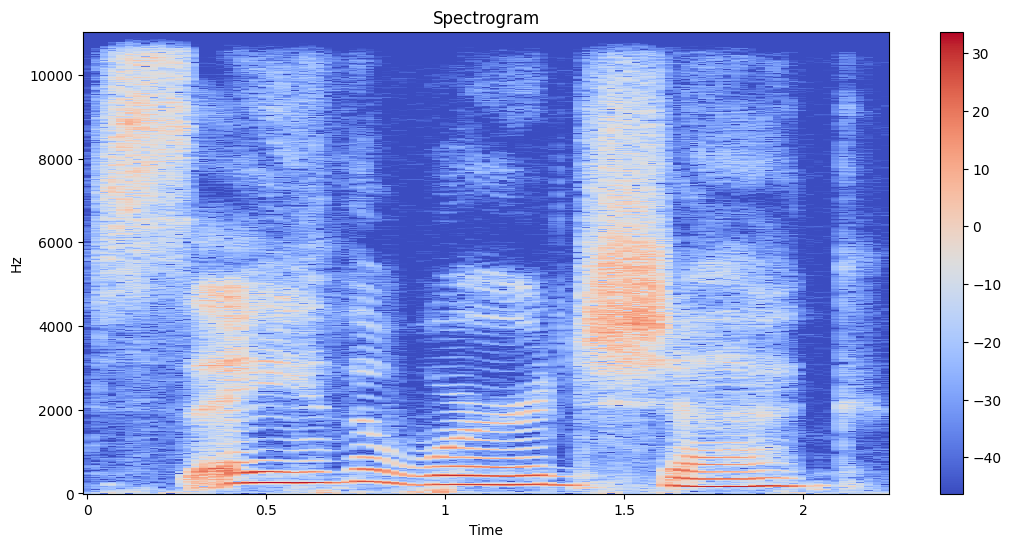

In [21]:
figure = plt.figure(figsize=(13,6))
audio_speech, rate = librosa.load(audio_df['audio_file'][2000])
stft_audio = librosa.stft(audio_speech)
Db_audio = librosa.amplitude_to_db(abs(stft_audio))
librosa.display.specshow(Db_audio, sr=rate, x_axis='time', y_axis='hz')
plt.title('Spectrogram')
plt.colorbar()
plt.show()

***Visualization of MFCCs of a Audio Sample***

In [22]:
audio_file, sr = librosa.load(audio_df['audio_file'][2000])
mfccs = librosa.feature.mfcc(y=audio_file, sr=sr, n_mfcc=13)

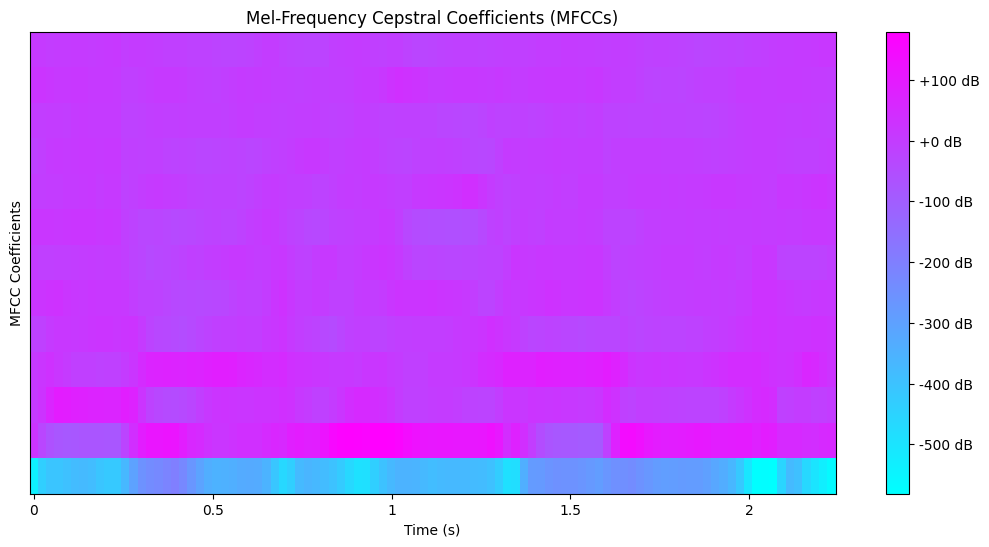

In [23]:
plt.figure(figsize=(13, 6))
librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap='cool')
plt.title('Mel-Frequency Cepstral Coefficients (MFCCs)')
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time (s)')
plt.ylabel('MFCC Coefficients')
plt.show()

***Preprocessing***

In [24]:
from sklearn.preprocessing import OneHotEncoder
encoder_label = OneHotEncoder()

X = feature_dataframe.iloc[:, :-1].values
emotions_array = feature_dataframe['EMOTIONS'].values.reshape(-1, 1)
Y = encoder_label.fit_transform(emotions_array).toarray()

print(X.shape)
print(Y.shape)


(11295, 20)
(11295, 14)


In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42, shuffle=True)

In [26]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(7906, 20)
(7906, 14)
(3389, 20)
(3389, 14)


In [27]:
from sklearn.preprocessing import StandardScaler
scaler_data = StandardScaler()

X_train = scaler_data.fit_transform(X_train)
X_test = scaler_data.transform(X_test)

***Model Creation (LSTM)***

In [28]:
timesteps = 1
num_features = X_train.shape[1]
X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)

In [29]:
print(X_train.shape)
print(X_test.shape)

(7906, 1, 20)
(3389, 1, 20)


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

In [31]:
def create_lstm_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(128, return_sequences=True),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer= optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [32]:
lstm_model = create_lstm_model((timesteps, num_features), Y.shape[1])
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │        76,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 14)             │           910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,606 (494.55 KB)

 Trainable params: 126,606 (494.55 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks = [ModelCheckpoint('speech-emotion-recognition.keras', verbose=1, save_best_only=True)]
history = lstm_model.fit(X_train, y_train, batch_size=64, epochs=50, callbacks=callbacks, validation_data=(X_test, y_test))

Epoch 1/50
120/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4042 - loss: 2.3519
Epoch 1: val_loss improved from inf to 0.95683, saving model to speech-emotion-recognition.keras
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4085 - loss: 2.3344 - val_accuracy: 0.7014 - val_loss: 0.9568
Epoch 2/50
114/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7514 - loss: 0.8119
Epoch 2: val_loss improved from 0.95683 to 0.40807, saving model to speech-emotion-recognition.keras
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7548 - loss: 0.8001 - val_accuracy: 0.8805 - val_loss: 0.4081
Epoch 3/50
111/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8759 - loss: 0.4129
Epoch 3: val_loss improved from 0.40807 to 0.24968, saving model to speech-emotion-recognition.keras
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8779 - loss: 0.4069 - val_accuracy: 0.9203 - val_loss: 0.2497
Epoch 4/50
111/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9200 - loss: 0.2637
Epoch 

***Visualization of Accuracy***

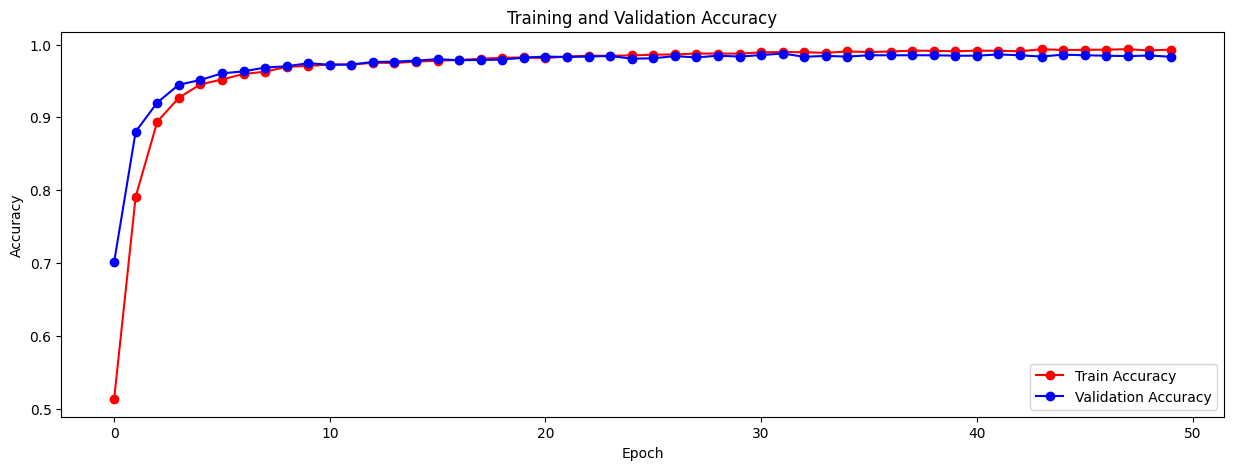

In [34]:
plt.figure(figsize=(15, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', color='red', marker='o', linestyle='-')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue', marker='o', linestyle='-')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

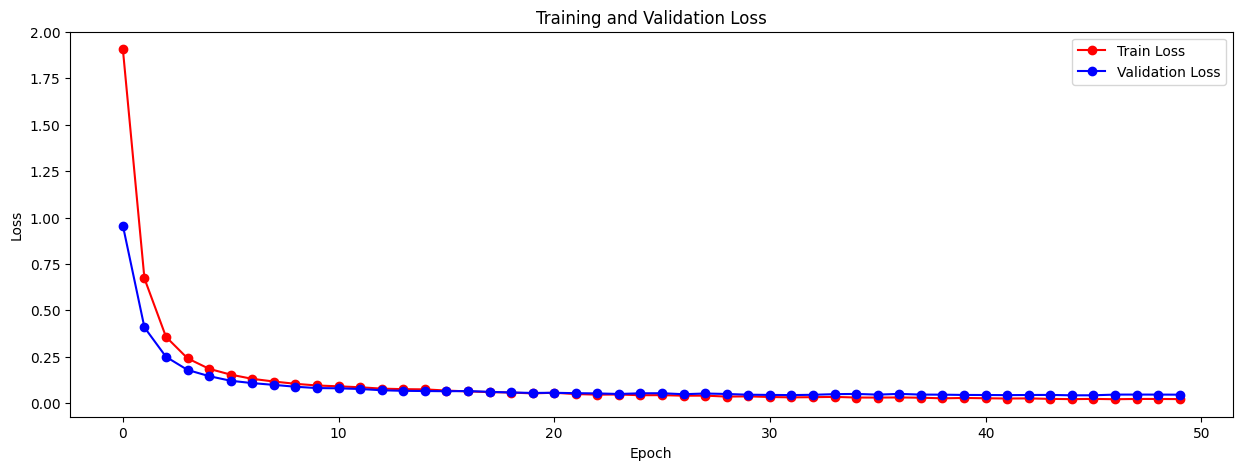

In [35]:
plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'], label='Train Loss', color='red', marker='o', linestyle='-')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue', marker='o', linestyle='-')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

***Test Output***

In [36]:
from tensorflow.keras.models import load_model

model = load_model('speech-emotion-recognition.keras')
results = model.evaluate(X_test, y_test)
print('Test loss:', results[0])
print('Test accuracy:', results[1])

106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9893 - loss: 0.0385
Test loss: 0.04233109578490257
Test accuracy: 0.9861316084861755


In [37]:
test_prediction = model.predict(X_test)
y_pred = encoder_label.inverse_transform(test_prediction)
y_test_inv = encoder_label.inverse_transform(y_test)

106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [38]:
print(y_pred[0:10])

[['OAF_Pleasant_surprise']
 ['YAF_fear']
 ['OAF_neutral']
 ['YAF_sad']
 ['OAF_Sad']
 ['YAF_fear']
 ['OAF_Pleasant_surprise']
 ['OAF_angry']
 ['OAF_neutral']
 ['OAF_Sad']]


In [39]:
print(y_test_inv[0:10])

[['OAF_Pleasant_surprise']
 ['YAF_fear']
 ['OAF_neutral']
 ['YAF_sad']
 ['OAF_Sad']
 ['YAF_fear']
 ['OAF_Pleasant_surprise']
 ['OAF_angry']
 ['OAF_neutral']
 ['OAF_Sad']]


***Confusion Matrix***

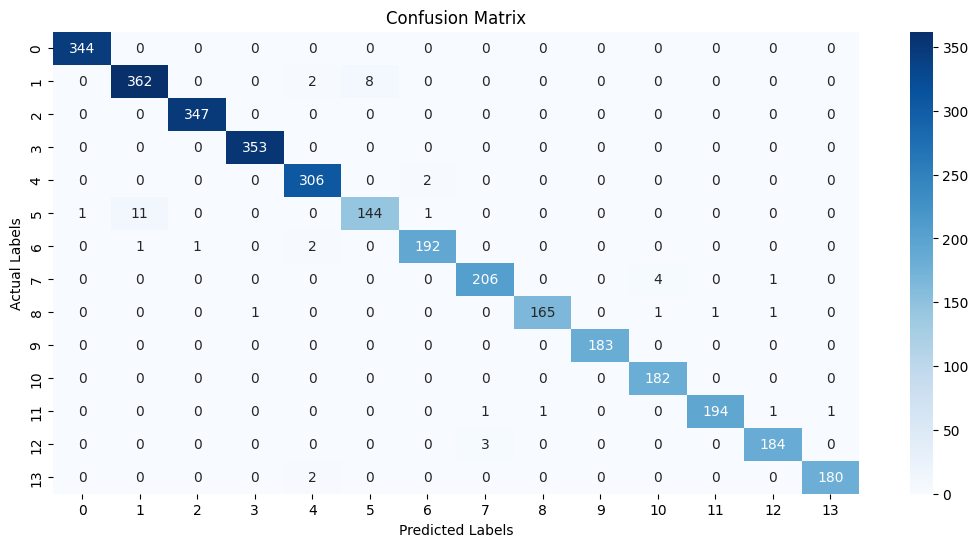

In [40]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_prediction, axis=1))
plt.figure(figsize=(13, 6))
sns.heatmap(conf_matrix, linecolor='white', cmap='Blues', annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

***Classification Report***

In [41]:
from sklearn.metrics import classification_report

print(classification_report(y_test_inv, y_pred))

                        precision    recall  f1-score   support

              OAF_Fear       1.00      1.00      1.00       344
 OAF_Pleasant_surprise       0.97      0.97      0.97       372
               OAF_Sad       1.00      1.00      1.00       347
             OAF_angry       1.00      1.00      1.00       353
           OAF_disgust       0.98      0.99      0.99       308
             OAF_happy       0.95      0.92      0.93       157
           OAF_neutral       0.98      0.98      0.98       196
             YAF_angry       0.98      0.98      0.98       211
           YAF_disgust       0.99      0.98      0.99       169
              YAF_fear       1.00      1.00      1.00       183
             YAF_happy       0.97      1.00      0.99       182
           YAF_neutral       0.99      0.98      0.99       198
YAF_pleasant_surprised       0.98      0.98      0.98       187
               YAF_sad       0.99      0.99      0.99       182

              accuracy                